In [1]:
import sys
from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference, gene_inference.utils
from gene_inference.models import lr, mlp, decision_tree
from gene_inference.infer_genes import infer_gene, infer_all_genes, sample_neighbors
from data.graph import Graph

/u/weissmar/venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import sys
sys.executable


'/u/weissmar/venv/bin/python'

In [3]:
tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [4]:
class Object(object):
    pass
opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue

In [5]:
graph = Graph()
graph.load_graph("/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5")
#graph.intersection_with(tcgatissue)

In [6]:
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)


In [8]:
# This reduces the number of genes that we're testing. 
# Remove the iloc to run the full dataset. Should take ~1.5 hours.

df = tcgatissue.df
lr_df = infer_all_genes(lr, df, train_size=100, test_size=300, trials=2, penalty=True).reset_index(drop=True)
mlp_df = infer_all_genes(mlp, df, train_size=100, test_size=300, trials=3, penalty=False).reset_index(drop=True)
dt_df = infer_all_genes(decision_tree, df, train_size=100, test_size=300, trials=3, penalty=False).reset_index(drop=True)


num genes: 163000, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,

3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498

7142, 7143, 7144, 7145, 7146, 7147, 7148, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7163, 7164, 7165, 7166, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179, 7180, 7181, 7182, 7183, 7184, 7185, 7186, 7187, 7188, 7189, 7190, 7191, 7192, 7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7264, 7265, 7266, 7267, 7268, 7269, 7270, 7271, 7272, 7273, 7274, 7275, 7276, 7277, 7278, 7279, 7280, 7281, 7282, 7283, 7284, 7285, 7286, 7287, 7288, 7289, 7290, 7291, 7292, 7293, 7294, 7295, 7296, 7297, 7298, 7299, 7300, 7301, 7302, 7303, 7304, 7305, 7306, 7307, 7308

11481, 11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494, 11495, 11496, 11497, 11498, 11499, 11500, 11501, 11502, 11503, 11504, 11505, 11506, 11507, 11508, 11509, 11510, 11511, 11512, 11513, 11514, 11515, 11516, 11517, 11518, 11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527, 11528, 11529, 11530, 11531, 11532, 11533, 11534, 11535, 11536, 11537, 11538, 11539, 11540, 11541, 11542, 11543, 11544, 11545, 11546, 11547, 11548, 11549, 11550, 11551, 11552, 11553, 11554, 11555, 11556, 11557, 11558, 11559, 11560, 11561, 11562, 11563, 11564, 11565, 11566, 11567, 11568, 11569, 11570, 11571, 11572, 11573, 11574, 11575, 11576, 11577, 11578, 11579, 11580, 11581, 11582, 11583, 11584, 11585, 11586, 11587, 11588, 11589, 11590, 11591, 11592, 11593, 11594, 11595, 11596, 11597, 11598, 11599, 11600, 11601, 11602, 11603, 11604, 11605, 11606, 11607, 11608, 11609, 11610, 11611, 11612, 11613, 11614, 11615, 11616, 11617, 11618, 11619, 11620, 11621, 11622, 11623,

15840, 15841, 15842, 15843, 15844, 15845, 15846, 15847, 15848, 15849, 15850, 15851, 15852, 15853, 15854, 15855, 15856, 15857, 15858, 15859, 15860, 15861, 15862, 15863, 15864, 15865, 15866, 15867, 15868, 15869, 15870, 15871, 15872, 15873, 15874, 15875, 15876, 15877, 15878, 15879, 15880, 15881, 15882, 15883, 15884, 15885, 15886, 15887, 15888, 15889, 15890, 15891, 15892, 15893, 15894, 15895, 15896, 15897, 15898, 15899, 15900, 15901, 15902, 15903, 15904, 15905, 15906, 15907, 15908, 15909, 15910, 15911, 15912, 15913, 15914, 15915, 15916, 15917, 15918, 15919, 15920, 15921, 15922, 15923, 15924, 15925, 15926, 15927, 15928, 15929, 15930, 15931, 15932, 15933, 15934, 15935, 15936, 15937, 15938, 15939, 15940, 15941, 15942, 15943, 15944, 15945, 15946, 15947, 15948, 15949, 15950, 15951, 15952, 15953, 15954, 15955, 15956, 15957, 15958, 15959, 15960, 15961, 15962, 15963, 15964, 15965, 15966, 15967, 15968, 15969, 15970, 15971, 15972, 15973, 15974, 15975, 15976, 15977, 15978, 15979, 15980, 15981, 15982,

3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545

7661, 7662, 7663, 7664, 7665, 7666, 7667, 7668, 7669, 7670, 7671, 7672, 7673, 7674, 7675, 7676, 7677, 7678, 7679, 7680, 7681, 7682, 7683, 7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693, 7694, 7695, 7696, 7697, 7698, 7699, 7700, 7701, 7702, 7703, 7704, 7705, 7706, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7714, 7715, 7716, 7717, 7718, 7719, 7720, 7721, 7722, 7723, 7724, 7725, 7726, 7727, 7728, 7729, 7730, 7731, 7732, 7733, 7734, 7735, 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7743, 7744, 7745, 7746, 7747, 7748, 7749, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7757, 7758, 7759, 7760, 7761, 7762, 7763, 7764, 7765, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 7773, 7774, 7775, 7776, 7777, 7778, 7779, 7780, 7781, 7782, 7783, 7784, 7785, 7786, 7787, 7788, 7789, 7790, 7791, 7792, 7793, 7794, 7795, 7796, 7797, 7798, 7799, 7800, 7801, 7802, 7803, 7804, 7805, 7806, 7807, 7808, 7809, 7810, 7811, 7812, 7813, 7814, 7815, 7816, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827

12045, 12046, 12047, 12048, 12049, 12050, 12051, 12052, 12053, 12054, 12055, 12056, 12057, 12058, 12059, 12060, 12061, 12062, 12063, 12064, 12065, 12066, 12067, 12068, 12069, 12070, 12071, 12072, 12073, 12074, 12075, 12076, 12077, 12078, 12079, 12080, 12081, 12082, 12083, 12084, 12085, 12086, 12087, 12088, 12089, 12090, 12091, 12092, 12093, 12094, 12095, 12096, 12097, 12098, 12099, 12100, 12101, 12102, 12103, 12104, 12105, 12106, 12107, 12108, 12109, 12110, 12111, 12112, 12113, 12114, 12115, 12116, 12117, 12118, 12119, 12120, 12121, 12122, 12123, 12124, 12125, 12126, 12127, 12128, 12129, 12130, 12131, 12132, 12133, 12134, 12135, 12136, 12137, 12138, 12139, 12140, 12141, 12142, 12143, 12144, 12145, 12146, 12147, 12148, 12149, 12150, 12151, 12152, 12153, 12154, 12155, 12156, 12157, 12158, 12159, 12160, 12161, 12162, 12163, 12164, 12165, 12166, 12167, 12168, 12169, 12170, 12171, 12172, 12173, 12174, 12175, 12176, 12177, 12178, 12179, 12180, 12181, 12182, 12183, 12184, 12185, 12186, 12187,

num genes: 163000, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,

4357, 4358, 4359, 4360, 4361, 4362, 4363, 4364, 4365, 4366, 4367, 4368, 4369, 4370, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4453, 4454, 4455, 4456, 4457, 4458, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521, 4522, 4523

8891, 8892, 8893, 8894, 8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8905, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8913, 8914, 8915, 8916, 8917, 8918, 8919, 8920, 8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928, 8929, 8930, 8931, 8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8940, 8941, 8942, 8943, 8944, 8945, 8946, 8947, 8948, 8949, 8950, 8951, 8952, 8953, 8954, 8955, 8956, 8957, 8958, 8959, 8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967, 8968, 8969, 8970, 8971, 8972, 8973, 8974, 8975, 8976, 8977, 8978, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8986, 8987, 8988, 8989, 8990, 8991, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999, 9000, 9001, 9002, 9003, 9004, 9005, 9006, 9007, 9008, 9009, 9010, 9011, 9012, 9013, 9014, 9015, 9016, 9017, 9018, 9019, 9020, 9021, 9022, 9023, 9024, 9025, 9026, 9027, 9028, 9029, 9030, 9031, 9032, 9033, 9034, 9035, 9036, 9037, 9038, 9039, 9040, 9041, 9042, 9043, 9044, 9045, 9046, 9047, 9048, 9049, 9050, 9051, 9052, 9053, 9054, 9055, 9056, 9057

13163, 13164, 13165, 13166, 13167, 13168, 13169, 13170, 13171, 13172, 13173, 13174, 13175, 13176, 13177, 13178, 13179, 13180, 13181, 13182, 13183, 13184, 13185, 13186, 13187, 13188, 13189, 13190, 13191, 13192, 13193, 13194, 13195, 13196, 13197, 13198, 13199, 13200, 13201, 13202, 13203, 13204, 13205, 13206, 13207, 13208, 13209, 13210, 13211, 13212, 13213, 13214, 13215, 13216, 13217, 13218, 13219, 13220, 13221, 13222, 13223, 13224, 13225, 13226, 13227, 13228, 13229, 13230, 13231, 13232, 13233, 13234, 13235, 13236, 13237, 13238, 13239, 13240, 13241, 13242, 13243, 13244, 13245, 13246, 13247, 13248, 13249, 13250, 13251, 13252, 13253, 13254, 13255, 13256, 13257, 13258, 13259, 13260, 13261, 13262, 13263, 13264, 13265, 13266, 13267, 13268, 13269, 13270, 13271, 13272, 13273, 13274, 13275, 13276, 13277, 13278, 13279, 13280, 13281, 13282, 13283, 13284, 13285, 13286, 13287, 13288, 13289, 13290, 13291, 13292, 13293, 13294, 13295, 13296, 13297, 13298, 13299, 13300, 13301, 13302, 13303, 13304, 13305,

In [9]:
# Predict a gene from a growing number of samples
gene = "RPL5"
max_train_size = 100
full_results = pd.DataFrame([])
first_degree_results = pd.DataFrame([])
first_degree = set(g.neighbors("RPL5"))
first_degree.add("RPL5")

for train_size in range(10, max_train_size, 10):
    print train_size
    
    full_results = full_results.append(infer_gene(lr, tcgatissue.df, "RPL5", train_size, test_size=200, trials=10, penalty=True)).reset_index(drop=True)
    full_results.loc[full_results.index[-1], 'samples'] = train_size
    first_degree_results = first_degree_results.append(infer_gene(lr, tcgatissue.df.loc[:, first_degree], "RPL5", train_size, test_size=200, trials=10, penalty=True)).reset_index(drop=True)
    first_degree_results.loc[first_degree_results.index[-1], 'samples'] = train_size

10
20
30
40
50
60
70
80
90


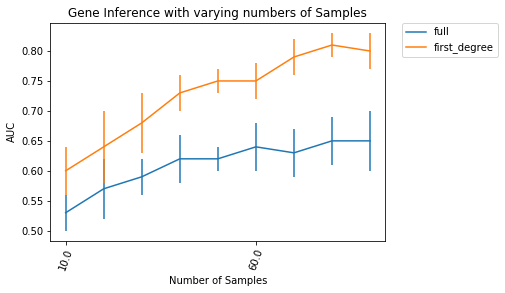

In [10]:
# results of adding Samples
plt.figure()

line1 = plt.errorbar(full_results.index, full_results['auc'], xerr=0, yerr=full_results['std'])
line2 = plt.errorbar(first_degree_results.index, first_degree_results['auc'], xerr=0, yerr=first_degree_results['std'])

width = 0.2
plt.xticks(list(full_results.iloc[::5, :].index), full_results.iloc[::5, :]['samples'], rotation=70)
plt.title("Gene Inference with varying numbers of Samples")
plt.ylabel("AUC")
plt.xlabel("Number of Samples")
plt.legend((line1[0], line2[0]), ('full', 'first_degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [11]:
# Predict a gene from a growing number of Nodes
results = pd.DataFrame([])
gene = "RPL5"
num_samples = 100
max_genes = 100

for num_genes in range(10, max_genes, 10):
    neighbors = sample_neighbors(g, "RPL5", num_genes)
    temp_df = tcgatissue.df.loc[:, neighbors]
    full_row = infer_gene(lr, temp_df, "RPL5", train_size=200, test_size=200, trials=10, penalty=False)
    results = results.append(full_row).reset_index(drop=True)
    results.loc[results.index[-1], 'num_genes'] = num_genes


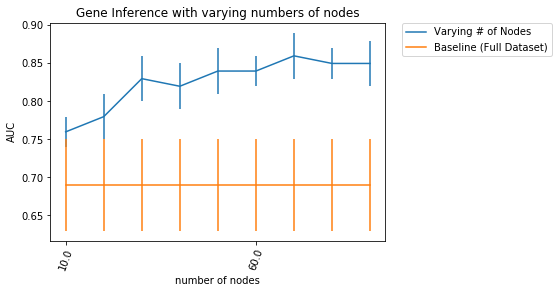

In [12]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(results.index, results['auc'], xerr=0, yerr=results['std'])
line2 = plt.errorbar(results.index, list(repeat(0.69, len(full_results))), xerr=0, yerr=list(repeat(0.06, len(full_results))))

width = 0.2
plt.xticks(list(results.iloc[::5, :].index), results.iloc[::5, :]['num_genes'], rotation=70)
plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.legend((line1[0], line2[0]), ('Varying # of Nodes', "Baseline (Full Dataset)"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [13]:
results

,auc,gene_name,num_genes,std
0,0.76,RPL5,10.0,0.02
1,0.78,RPL5,20.0,0.03
2,0.83,RPL5,30.0,0.03
3,0.82,RPL5,40.0,0.03
4,0.84,RPL5,50.0,0.03
5,0.84,RPL5,60.0,0.02
6,0.86,RPL5,70.0,0.03
7,0.85,RPL5,80.0,0.02
8,0.85,RPL5,90.0,0.03


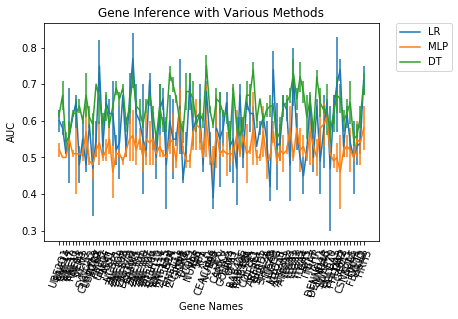

In [15]:
# AUC
plt.figure()

line1 = plt.errorbar(lr_df.index, lr_df['auc'], xerr=0, yerr=lr_df['std'])
line2 = plt.errorbar(mlp_df.index, mlp_df['auc'], xerr=0, yerr=mlp_df['std'])
line3 = plt.errorbar(dt_df.index, dt_df['auc'], xerr=0, yerr=dt_df['std'])

width = 0.2
plt.xticks(lr_df.index, lr_df['gene_name'], rotation=70)
plt.title("Gene Inference with Various Methods")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.legend((line1[0], line2[0], line3[0]), ('LR', 'MLP', 'DT'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [ ]:
# LR 
plt.figure()
line1 = plt.errorbar(lr_df.index, lr_df['auc'], xerr=0, yerr=lr_df['std'])
line2 = plt.errorbar(lr_df.index, lr_df['first_degree_auc'], xerr=0, yerr=lr_df['first_degree_std'])
line3 = plt.errorbar(lr_df.index, lr_df['second_degree_auc'], xerr=0, yerr=lr_df['second_degree_std'])

width = 0.2
plt.xticks(lr_df.index, lr_df['gene_name'], rotation=70)
plt.title("Gene Inference with LR")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.legend((line1[0], line2[0], line3[0]), ('Full Dataset', 'First Degree', 'Second Degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

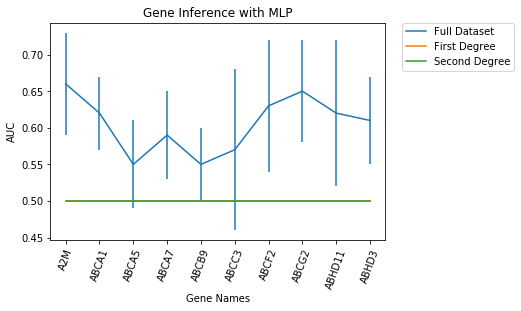

In [24]:
#mlp
plt.figure()
line1 = plt.errorbar(mlp_df.index, mlp_df['auc'], xerr=0, yerr=mlp_df['std'])
line2 = plt.errorbar(mlp_df.index, mlp_df['first_degree_auc'], xerr=0, yerr=mlp_df['first_degree_std'])
line3 = plt.errorbar(mlp_df.index, mlp_df['second_degree_auc'], xerr=0, yerr=mlp_df['second_degree_std'])

width = 0.2
plt.xticks(mlp_df.index, mlp_df['gene_name'], rotation=70)
plt.title("Gene Inference with MLP")
plt.ylabel("AUC")
plt.xlabel("Gene Names")
plt.legend((line1[0], line2[0], line3[0]), ('Full Dataset', 'First Degree', 'Second Degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

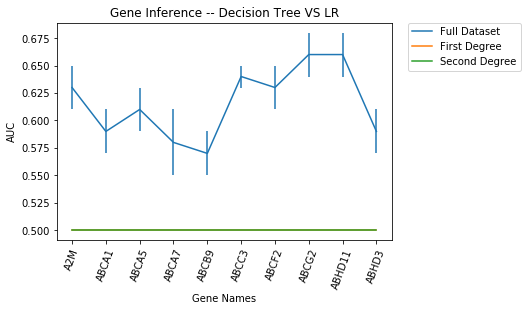

In [26]:
# Decision Tree
plt.figure()

line1 = plt.errorbar(dt_df.index, dt_df['auc'], xerr=0, yerr=dt_df['std'])
line2 = plt.errorbar(dt_df.index, dt_df['first_degree_auc'], xerr=0, yerr=dt_df['first_degree_std'])
line3 = plt.errorbar(dt_df.index, dt_df['second_degree_auc'], xerr=0, yerr=dt_df['second_degree_std'])

width = 0.2
plt.xticks(dt_df.index, dt_df['gene_name'], rotation=70)
plt.title("Gene Inference -- Decision Tree VS LR")
plt.ylabel("AUC")
plt.xlabel("Gene Names")

# Legend
plt.legend((line1[0], line2[0], line3[0]), ('Full Dataset', 'First Degree', 'Second Degree'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)


In [ ]:
# Graphical Character example

In [455]:
# 1st degree
first_degree_neighbors = g.neighbors("RPL5")
first_degree_neighbor_subgraph = g.subgraph(first_degree_neighbors)

'num nodes:29'

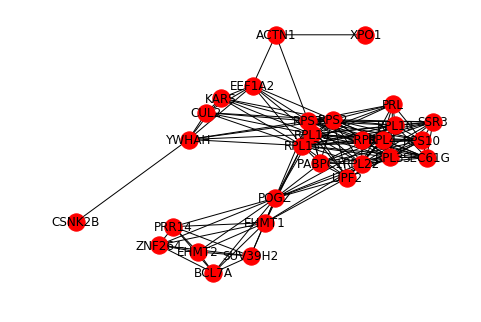

In [456]:
pos = nx.spring_layout(first_degree_neighbor_subgraph, k=1.45,iterations=100)
nx.draw(first_degree_neighbor_subgraph, pos=pos, with_labels=True)
"num nodes:" + str(len([x for x  in g.neighbors("RPL5")]))

In [299]:
# 2nd degree
second_degree_neighborhood = []
for n in g.neighbors("RPL5"):
    second_degree_neighborhood.extend(g.neighbors(n))
second_degree_subgraph = g.subgraph(second_degree_neighborhood)

'num nodes:1147'

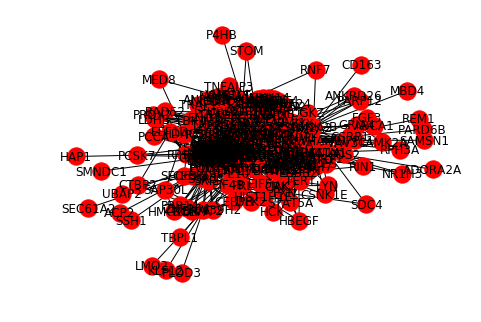

In [300]:
pos = nx.spring_layout(second_degree_subgraph, k=.25,iterations=100)
nx.draw(second_degree_subgraph, pos=pos, with_labels=True)
"num nodes:" + str(len(second_degree_neighborhood))